# Scaling Python with Azure ML and Dask

![Describe gif](media/describe3.gif)

## Environment setup

This notebook assumes you are using an Azure ML Compute Instance with the default kernel `azureml_py36`. This contains many unneccesary packages and is missing some packages needed for running dask. The below cells will upgrade/install these packages.

It is important that the local environment matches the remote environment to avoid mismatch issues when submitting commands to the remote cluster. To help with this, we will use Azure ML Environments. If you want to avoid a long image build time, you may want to create a new conda environment with the minimal packages needed for your scenario. 

In [1]:
pip install --upgrade azureml-sdk[notebooks] azureml-dataprep[fuse] fastparquet pyarrow dask distributed lz4

     |████████████████████████████████| 26.9MB 13.7MB/s eta 0:00:01
     |████████████████████████████████| 153kB 48.9MB/s eta 0:00:01
     |████████████████████████████████| 59.2MB 50.2MB/s eta 0:00:01
     |████████████████████████████████| 778kB 44.7MB/s eta 0:00:01
     |████████████████████████████████| 583kB 46.4MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 49.4MB/s eta 0:00:01
     |████████████████████████████████| 1.2MB 47.4MB/s eta 0:00:01
     |████████████████████████████████| 13.9MB 39.2MB/s eta 0:00:01
     |████████████████████████████████| 1.3MB 42.0MB/s eta 0:00:01
     |████████████████████████████████| 61kB 28.3MB/s eta 0:00:01
     |████████████████████████████████| 8.6MB 43.4MB/s eta 0:00:01
     |████████████████████████████████| 276kB 51.2MB/s eta 0:00:01
     |████████████████████████████████| 51kB 27.4MB/s eta 0:00:01
     |████████████████████████████████| 460kB 48.6MB/s eta 0:00:01
  Created wheel for fastparquet: filename=fastparquet-0.3.2-c

In [2]:
pip uninstall azureml-samples -y

Uninstalling azureml-samples-0+unknown:
  Successfully uninstalled azureml-samples-0+unknown
Note: you may need to restart the kernel to use updated packages.


In [3]:
# restart kernel
from IPython.core.display import HTML
HTML('<script>Jupyter.notebook.kernel.restart()</script>')

## Imports

Import all packages used in this notebook.

In [4]:
import os
import sys
import dask
import glob
import socket
import matplotlib

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from IPython.core.display import HTML

from azureml.widgets import RunDetails
from azureml.train.estimator import Estimator
from azureml.core.runconfig import MpiConfiguration
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.core import Workspace, Experiment, Dataset, Environment

%matplotlib inline 

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception cannot import name '_DistributedTraining'.


## Azure ML Setup

Get the workspace.

In [6]:
ws = Workspace.from_config()
ws

Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')

### Create environment 

Create the environment to be used on the remote cluster. 

In [7]:
env_name = 'dask-remote'

if env_name not in ws.environments:
    env = Environment.from_existing_conda_environment(env_name, 'azureml_py36')
    env.python.conda_dependencies.add_pip_package('mpi4py') # needed for remote cluster
    env = env.register(ws)
else:
    env = ws.environments[env_name]
    
env.name, env.version

Exporting conda specifications for existing conda environment: azureml_py36


('dask-remote', '1')

### Create dataset

Create the dataset to be used. 

In [8]:
dataset_name = 'weather-files'
data_paths   = ['https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet']

if dataset_name not in ws.datasets:
    ds = Dataset.File.from_files(data_paths, validate=False)
    ds = ds.register(ws, dataset_name)
else:
    ds = ws.datasets[dataset_name]
    
ds

{
  "source": [
    "https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet"
  ],
  "definition": [
    "GetFiles"
  ],
  "registration": {
    "id": "132f84ee-4f89-45f7-b2ca-fe22fe332295",
    "name": "weather-files",
    "version": 1,
    "workspace": "Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')"
  }
}

### Create VM pool

Create Azure ML VM pool for creating remote dask cluster(s).

In [9]:
pool_name = 'dask-cluster'

if pool_name not in ws.compute_targets:
    # create config for Azure ML cluster
    # change properties as needed
    config = AmlCompute.provisioning_configuration(
             vm_size                 = 'STANDARD_DS13_V2',
             max_nodes               = 100,
             vnet_resourcegroup_name = ws.resource_group,
             vnet_name               = 'dask-vnet',
             subnet_name             = 'default'
    )
    
    ct = ComputeTarget.create(ws, pool_name, config)
    ct.wait_for_completion(show_output=True)    
else:
    ct = ws.compute_targets[pool_name]
    
ct

AmlCompute(workspace=Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg'), name=dask-cluster, id=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/copetersrg/providers/Microsoft.MachineLearningServices/workspaces/bigdata/computes/dask-cluster, type=AmlCompute, provisioning_state=Succeeded, location=northcentralus, tags=None)

## 600 GB Dataset

Expanded in memory, the full dataset is ~660 GB.

It is under https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather.

Under the container, the format is `year=*/month=*/part-*.snappy.parquet`.

It is compressed with SNAPPY, reducing the size of files to about 8 GB.

Without compression, the data is about 160 GB stored on disk in parquet or CSV. 

In memory, the data is about 660 GB.

## Download dataset

In [10]:
data_path = '/mnt/noaa'
os.system('sudo chmod 777 /mnt') # stupid 

0

In [11]:
ds.download(data_path)

array(['/mnt/noaa/year=2008/month=1/part-00005-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-6.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=10/part-00001-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-2.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=11/part-00006-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-7.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=12/part-00000-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-1.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=2/part-00011-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-12.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=3/part-00003-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-4.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=4/part-00008-tid-7339844144521752319-f39253b3-5b5d-4d3f-94e0-5bba3b8b843a-9.c000.snappy.parquet',
       '/mnt/noaa/year=2008/month=5/part-00002-tid-7339844144521752319-f

In [12]:
files = glob.glob(f'{data_path}/year=*/month=*/*.parquet', recursive=True)
len(files)

144

## Pandas

In [13]:
files = glob.glob(f'{data_path}/year=2019/month=12/*.parquet', recursive=True) # 1 month of data
files

['/mnt/noaa/year=2019/month=12/part-00024-tid-3153355563025261095-9b1a8cb5-d26f-4c07-b535-6021cc19a08d-73549-1.c000.snappy.parquet']

In [14]:
df = pd.read_parquet(files[0])
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,040131,99999,2019-12-01 09:00:00,66.058,-23.135,2.0,190.0,1.5,3.0,NaN,...,NaN,NaN,NaN,NaN,ISAFJORDUR,IC,040131-99999,2019,1,1.0
1,040131,99999,2019-12-01 10:00:00,66.058,-23.135,2.0,210.0,1.5,1.0,NaN,...,NaN,NaN,NaN,NaN,ISAFJORDUR,IC,040131-99999,2019,1,1.0
2,040131,99999,2019-12-01 11:00:00,66.058,-23.135,2.0,210.0,1.5,1.0,NaN,...,NaN,NaN,NaN,NaN,ISAFJORDUR,IC,040131-99999,2019,1,1.0
3,040131,99999,2019-12-01 11:48:00,66.058,-23.135,2.0,200.0,1.5,1.0,NaN,...,NaN,NaN,NaN,NaN,ISAFJORDUR,IC,040131-99999,2019,1,1.0
4,040131,99999,2019-12-01 13:00:00,66.058,-23.135,2.0,0.0,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,ISAFJORDUR,IC,040131-99999,2019,1,1.0


In [15]:
%time len(df)

CPU times: user 20 µs, sys: 5 µs, total: 25 µs
Wall time: 28.6 µs


8577066

In [16]:
%time df.describe()

CPU times: user 5.16 s, sys: 1.2 s, total: 6.36 s
Wall time: 6.37 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,8.577066e+06,8.577066e+06,8.577066e+06,8.024382e+06,8.234278e+06,8.386456e+06,3.972064e+06,1.187061e+06,454073.000000,2.081660e+06,2.081660e+06,120169.000000,8577066.0,8.577066e+06,8577066.0
mean,3.560827e+01,-2.641260e+01,3.582731e+02,1.671673e+02,3.520887e+00,5.744058e+00,1.013557e+03,3.465944e+01,3.785772,1.663873e+01,2.525720e+03,11.076559,2019.0,1.387311e+01,1.0
std,2.468172e+01,7.897241e+01,7.007950e+02,1.135590e+02,3.059451e+00,1.257814e+01,1.156815e+01,3.007614e+01,3.024265,3.034052e+01,4.335866e+03,18.535429,0.0,7.761420e+00,0.0
min,-9.000000e+01,-1.799830e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-8.400000e+01,8.614000e+02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,2019.0,1.000000e+00,1.0
25%,3.235000e+01,-9.171700e+01,3.200000e+01,6.000000e+01,1.500000e+00,-1.200000e+00,1.008200e+03,5.000000e+00,1.000000,1.000000e+00,0.000000e+00,1.000000,2019.0,7.000000e+00,1.0
50%,4.160700e+01,-5.057800e+01,1.600000e+02,1.800000e+02,3.000000e+00,5.000000e+00,1.014600e+03,2.200000e+01,4.000000,3.000000e+00,1.000000e+00,1.000000,2019.0,1.400000e+01,1.0
75%,4.905200e+01,2.103000e+01,3.970000e+02,2.600000e+02,5.000000e+00,1.300000e+01,1.021100e+03,6.100000e+01,7.000000,2.400000e+01,9.999000e+03,16.000000,2019.0,2.100000e+01,1.0
max,8.365000e+01,1.797500e+02,9.999000e+03,3.600000e+02,8.800000e+01,6.000000e+01,1.088500e+03,9.900000e+01,9.000000,9.900000e+01,9.999000e+03,390.000000,2019.0,2.800000e+01,1.0


In [17]:
%time bites = df.memory_usage(index=True, deep=True).sum()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 4.09 s, sys: 0 ns, total: 4.09 s
Wall time: 4.06 s
Dataframe is: 4.13GB


In [18]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean()
means.head()

CPU times: user 672 ms, sys: 212 ms, total: 884 ms
Wall time: 898 ms


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2019-12-01,35.686406,-28.228631,360.279009,175.478089,3.981853,5.855555,1013.548670,44.089766,4.049514,15.576153,2237.343285,10.264063,2019,1,1.0
2019-12-02,35.524872,-26.631495,355.031343,193.481755,3.729187,5.131964,1013.759784,41.709580,4.231822,15.832952,2344.925119,10.387519,2019,2,1.0
2019-12-03,35.485145,-26.304343,356.857961,183.229631,3.412932,5.284842,1013.719291,36.478101,3.939732,16.800916,2509.195679,10.471727,2019,3,1.0
2019-12-04,35.678084,-26.293551,359.822438,179.825158,3.345195,5.907510,1012.489230,35.251974,3.690280,17.079001,2592.681675,8.721561,2019,4,1.0
2019-12-05,35.765118,-26.842292,365.346560,170.223266,3.381196,5.905347,1013.816391,34.091815,3.421430,15.732757,2460.998874,9.972270,2019,5,1.0


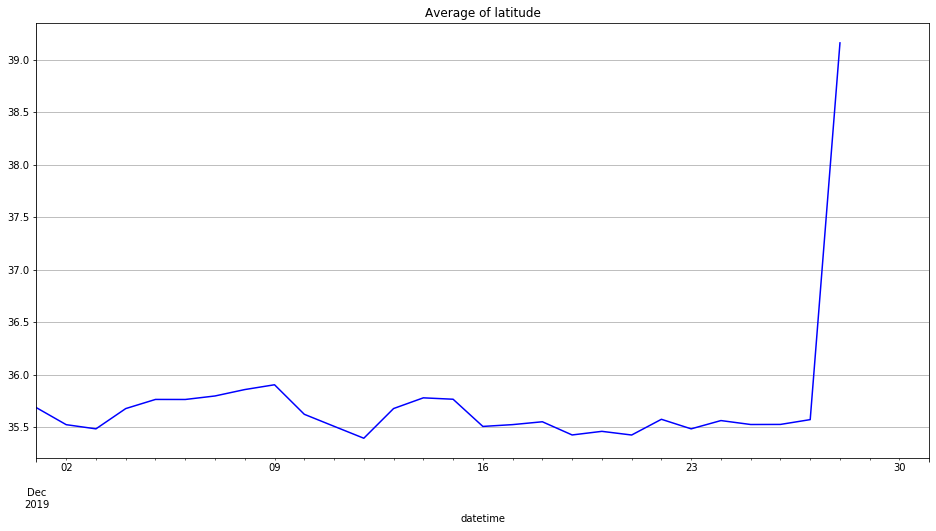

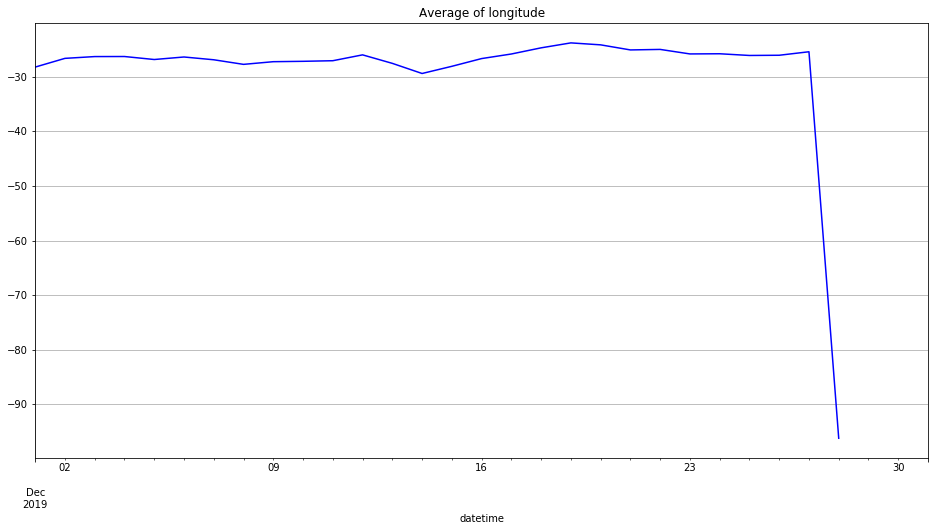

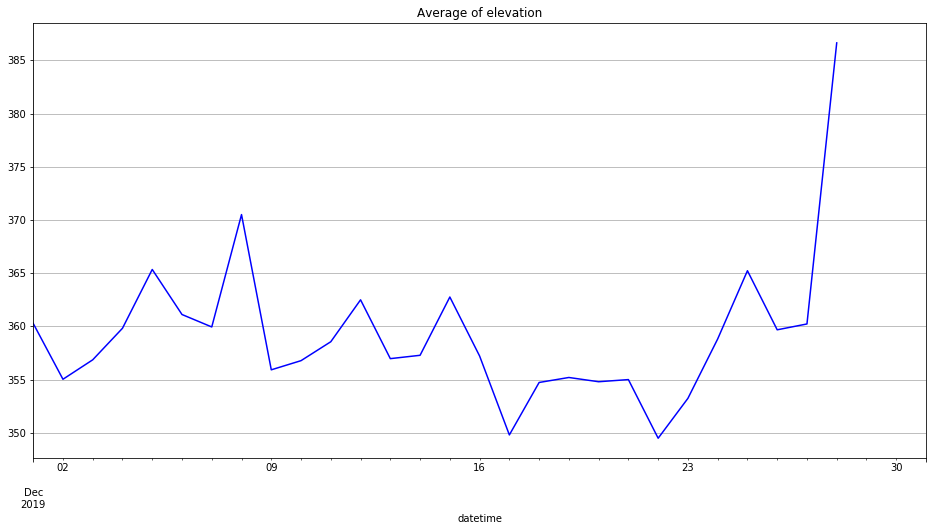

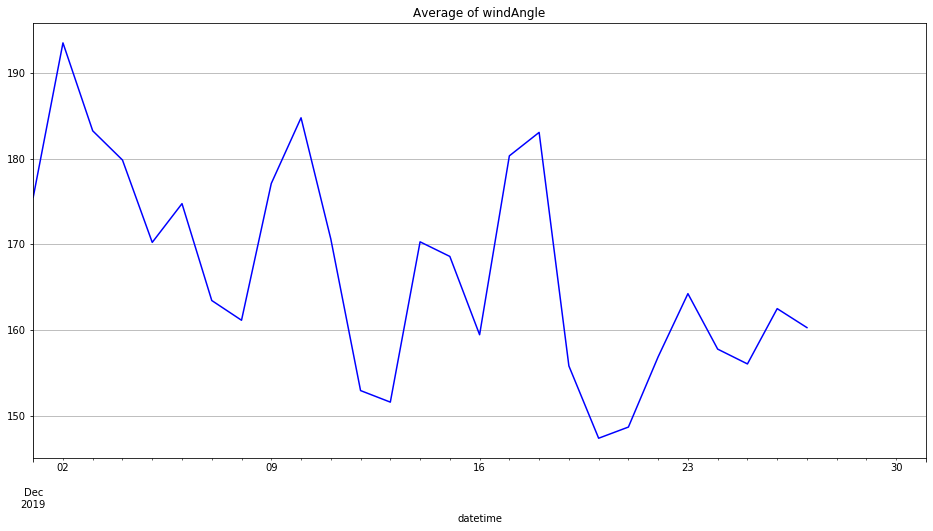

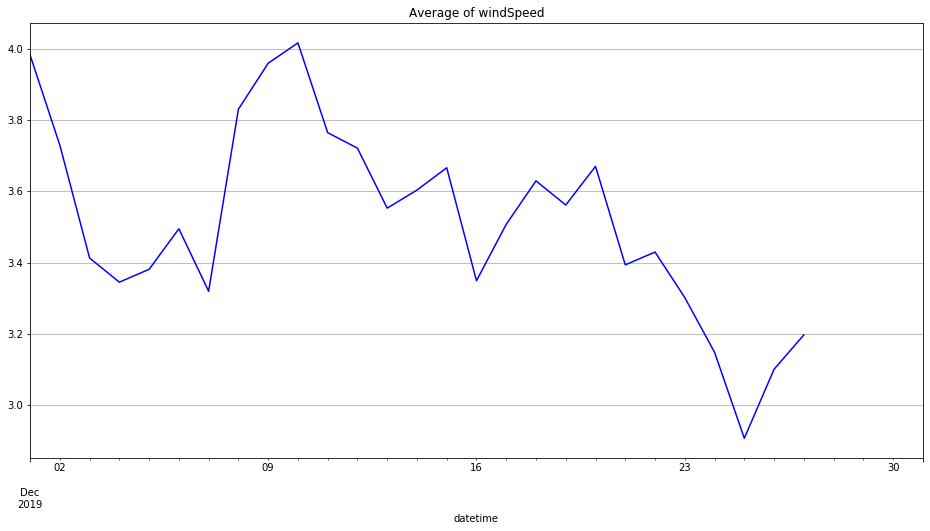

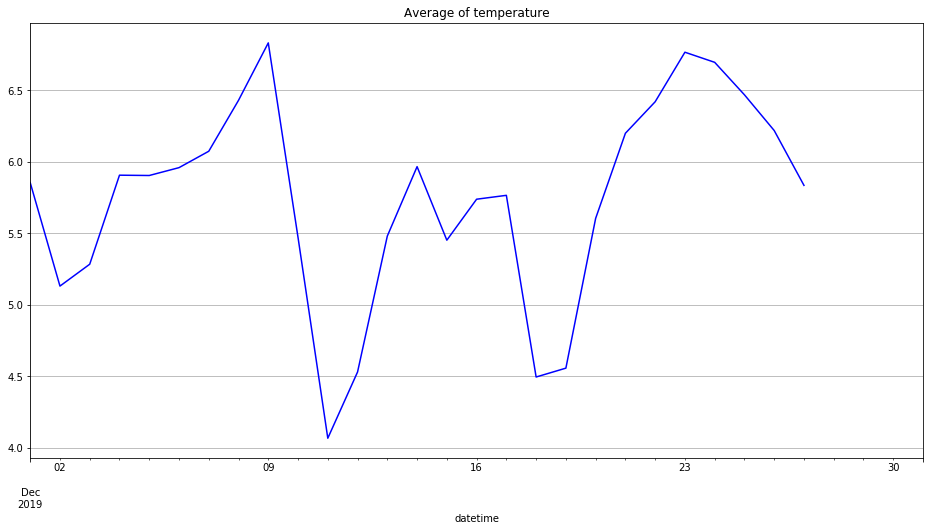

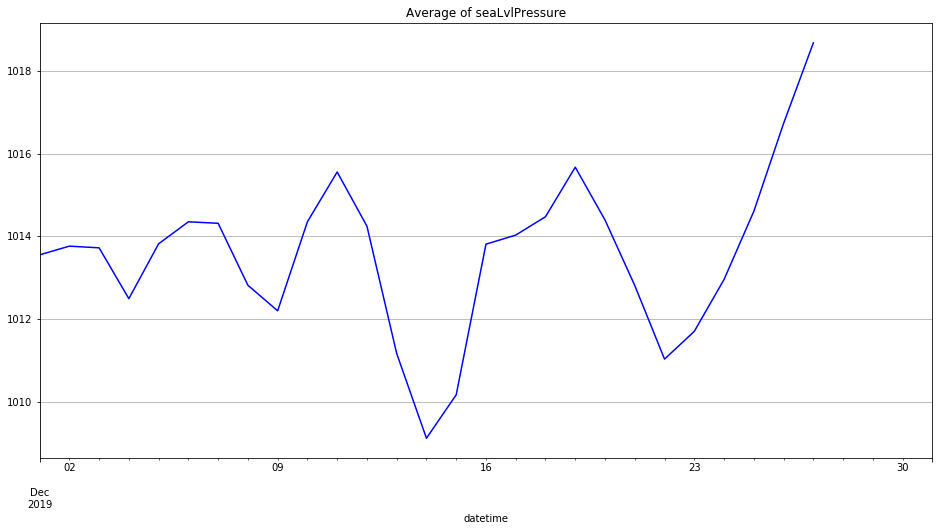

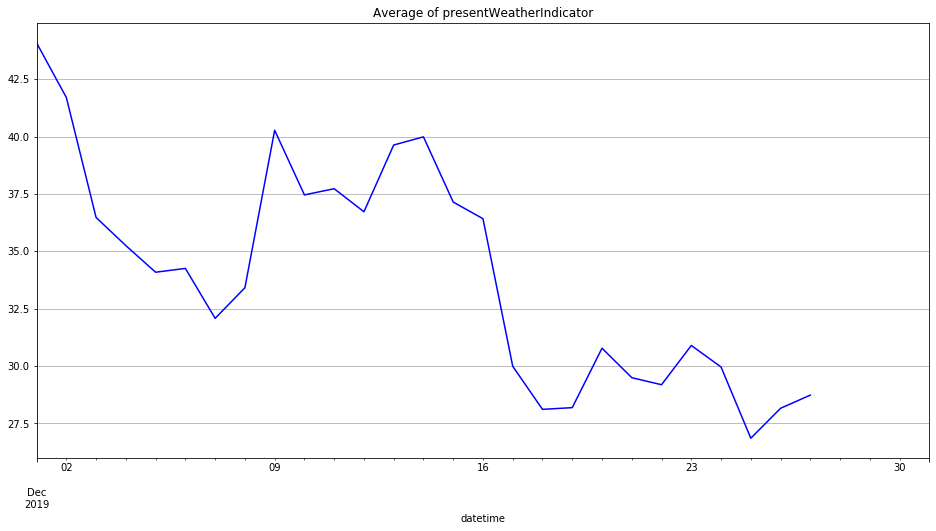

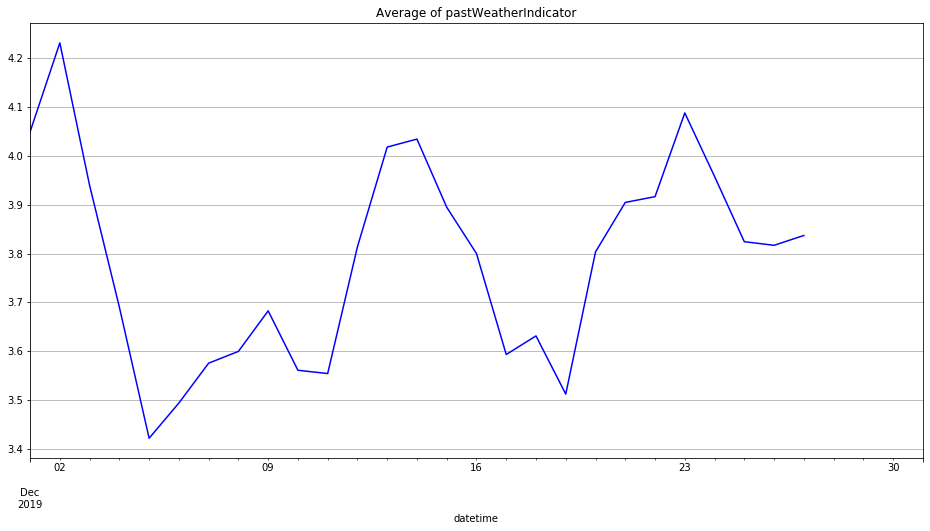

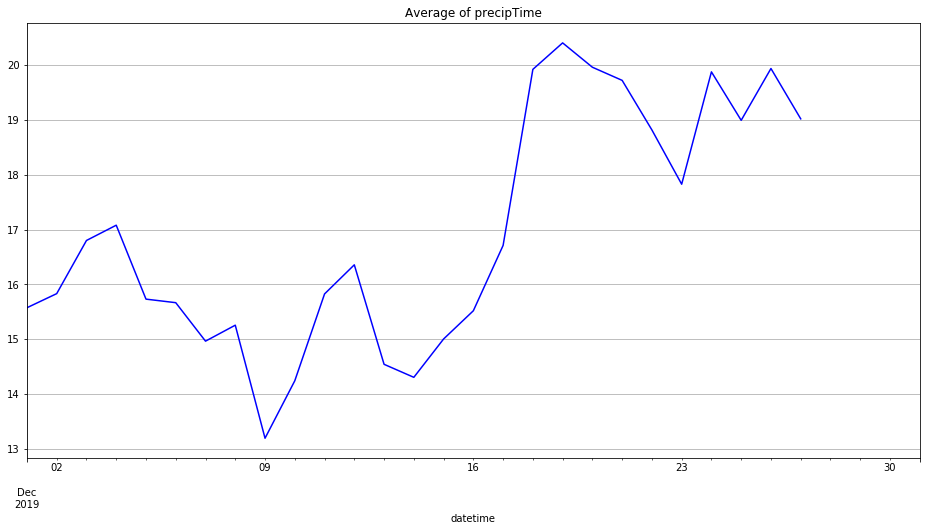

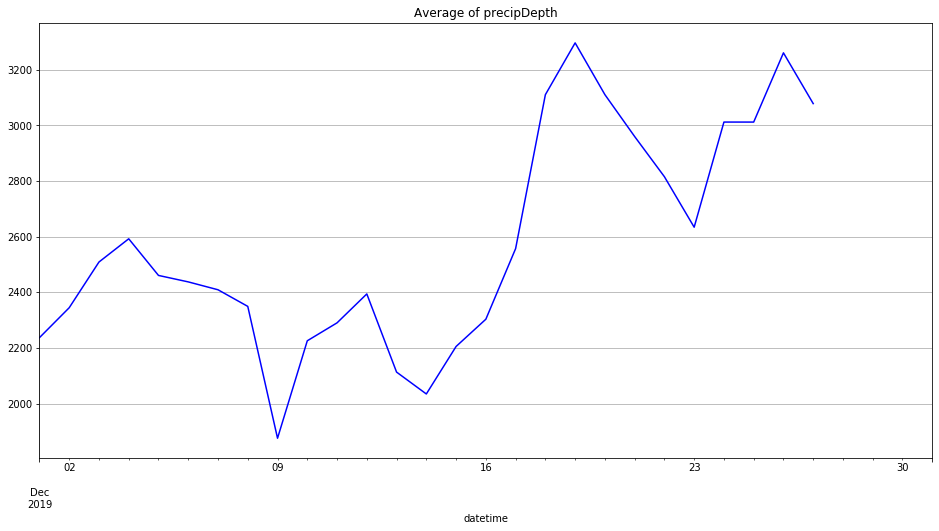

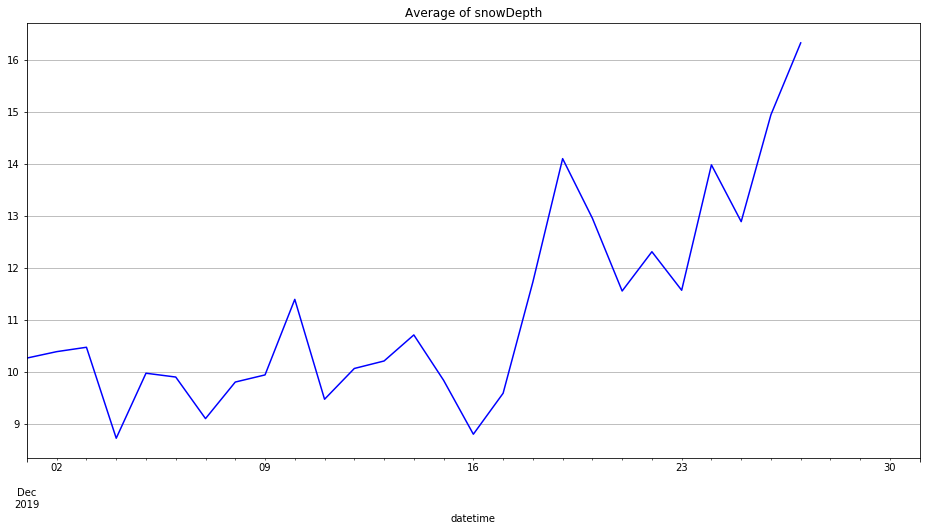

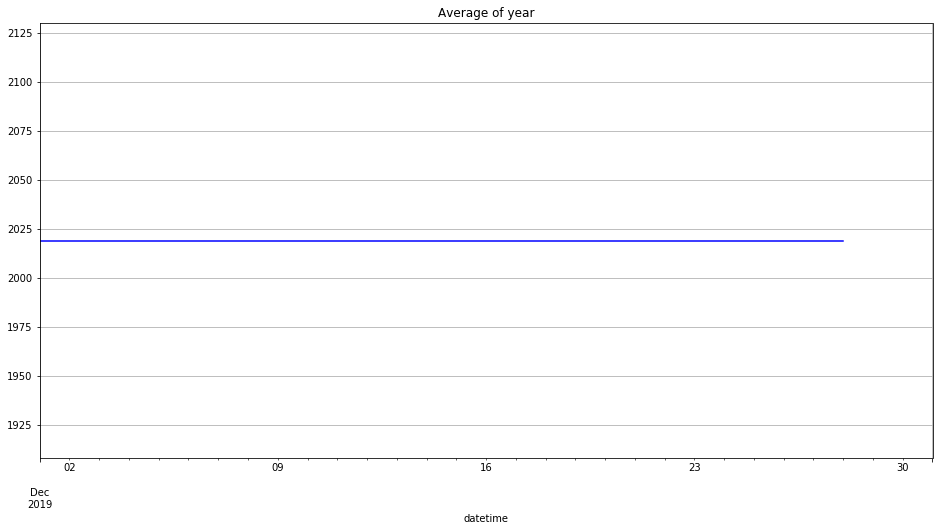

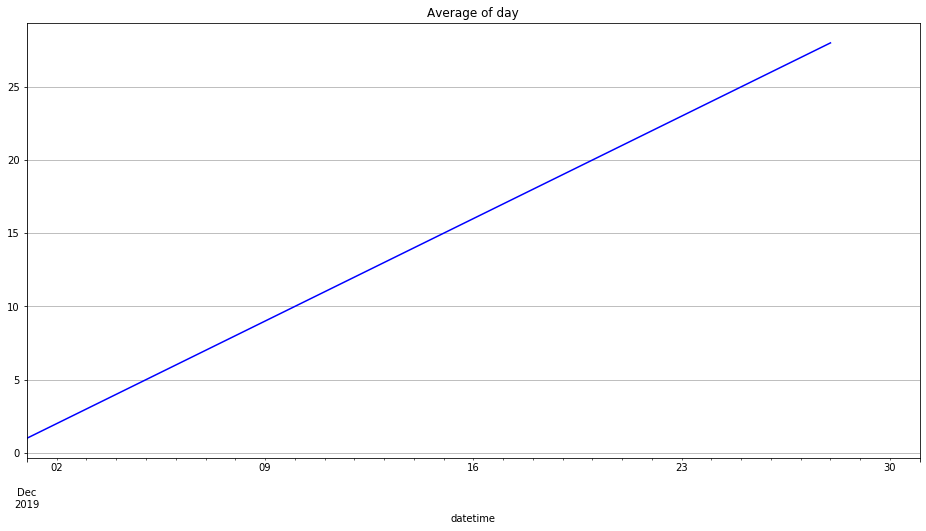

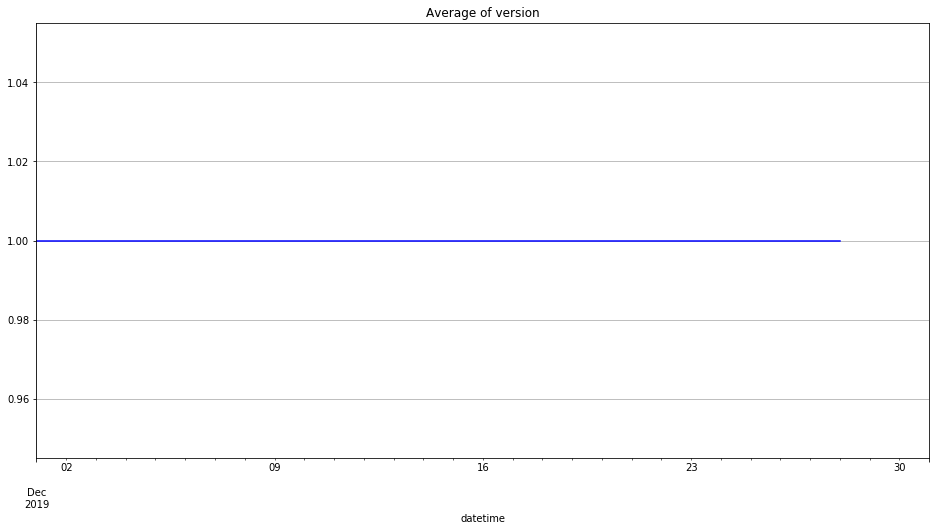

In [19]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2019, 12, 1), datetime(2019, 12, 31)])
    plt.grid()

## Scaling with Dask

The first step in scaling up with Dask is to simply get a bigger VM. For non-GPU Compute Instances, the max is the `STANDARD_DS15_V2` with 20 cores and 140 GB of RAM. This is suitable for interactive querying and data preparation on about 1 year of the weather data, but not on the full dataset.

In [20]:
dashboard_port = 9777

c = Client(dashboard_address=f':{dashboard_port}')
c.restart()

print(f'\n\n{c}')

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker




<Client: 'tcp://127.0.0.1:41263' processes=4 threads=8, memory=59.08 GB>


### Take 1 year of data

Start with 1 year of data. This is near the limit for relatively quick interactive data prep on my VM.

In [21]:
#files = dask.delayed(glob.glob)(f'{data_path}/year=2019/month=[6-12]/*.parquet', recursive=True).compute()  # 6 months of data
files = dask.delayed(glob.glob)(f'{data_path}/year=2019/month=*/*.parquet', recursive=True).compute()       # 1 year of data
#files = dask.delayed(glob.glob)(f'{data_path}/year=201[8-9]/month=*/*.parquet', recursive=True).compute()   # 2 years of data
#files = dask.delayed(glob.glob)(f'{data_path}/year=201?/month=*/*.parquet', recursive=True).compute()       # 10 years of data
len(files)

12

In [22]:
df = dd.from_delayed([dask.delayed(pd.read_parquet)(file) for file in files])
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,999999,26563,2019-05-01 00:00:00,60.724,-150.448,86.0,NaN,1.1,13.4,NaN,...,NaN,1.0,0.0,NaN,KENAI 29 ENE,US,999999-26563,2019,1,1.0
1,999999,26563,2019-05-01 00:05:00,60.724,-150.448,86.0,NaN,NaN,13.5,NaN,...,NaN,NaN,NaN,NaN,KENAI 29 ENE,US,999999-26563,2019,1,1.0
2,999999,26563,2019-05-01 00:10:00,60.724,-150.448,86.0,NaN,NaN,13.7,NaN,...,NaN,NaN,NaN,NaN,KENAI 29 ENE,US,999999-26563,2019,1,1.0
3,999999,26563,2019-05-01 00:15:00,60.724,-150.448,86.0,NaN,NaN,13.6,NaN,...,NaN,NaN,NaN,NaN,KENAI 29 ENE,US,999999-26563,2019,1,1.0
4,999999,26563,2019-05-01 00:20:00,60.724,-150.448,86.0,NaN,NaN,13.8,NaN,...,NaN,NaN,NaN,NaN,KENAI 29 ENE,US,999999-26563,2019,1,1.0


In [23]:
%time len(df)

CPU times: user 874 ms, sys: 96 ms, total: 970 ms
Wall time: 11.8 s


124956666

In [24]:
%time df.describe().compute()

CPU times: user 9.19 s, sys: 1.13 s, total: 10.3 s
Wall time: 1min 32s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.249567e+08,1.249567e+08,1.249567e+08,1.066881e+08,1.105223e+08,1.222281e+08,5.175650e+07,1.298102e+07,4.331517e+06,3.038590e+07,3.038590e+07,1.033798e+06,124956666.0,1.249567e+08,124956666.0
mean,3.605756e+01,-3.450950e+01,3.812591e+02,1.661066e+02,3.398631e+00,1.246802e+01,1.014604e+03,3.558280e+01,4.214374e+00,1.607452e+01,2.462784e+03,1.392134e+01,2019.0,1.550841e+01,1.0
std,2.368553e+01,7.841385e+01,6.997652e+02,1.140600e+02,2.818132e+00,1.257927e+01,9.117536e+00,3.022886e+01,3.022310e+00,3.064271e+01,4.298749e+03,2.493581e+01,0.0,8.755722e+00,0.0
min,-9.000000e+01,-1.799830e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.614000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2019.0,1.000000e+00,1.0
25%,3.283500e+01,-9.120000e+01,3.700000e+01,7.000000e+01,1.500000e+00,7.000000e+00,1.011000e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2019.0,8.000000e+00,1.0
50%,4.170600e+01,-4.545400e+01,1.810000e+02,1.900000e+02,3.100000e+00,1.590000e+01,1.017300e+03,6.000000e+01,5.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,2019.0,1.600000e+01,1.0
75%,4.922000e+01,2.136700e+01,4.350000e+02,2.800000e+02,5.100000e+00,2.700000e+01,1.024600e+03,7.100000e+01,8.000000e+00,2.400000e+01,9.999000e+03,5.100000e+01,2019.0,2.400000e+01,1.0
max,8.365600e+01,1.797500e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.150000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,7.000000e+02,2019.0,3.100000e+01,1.0


In [25]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 1.27 s, sys: 234 ms, total: 1.5 s
Wall time: 26.2 s
Dataframe is: 59.99GB


In [26]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean().compute()
means.head()

CPU times: user 13.8 s, sys: 2.55 s, total: 16.4 s
Wall time: 5min 7s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2019-05-01,36.199413,-37.102809,389.917542,167.145221,3.473469,13.240080,1014.932042,36.795622,4.394744,15.978500,2362.388684,9.093074,2019.0,1.0,1.0
2019-05-02,36.392980,-38.127867,379.394971,169.728057,3.465423,13.317345,1013.446821,37.820900,4.358315,15.582570,2336.450513,9.571782,2019.0,2.0,1.0
2019-05-03,36.345473,-37.795219,377.190112,167.830096,3.265668,13.333029,1013.320160,37.378743,4.593842,14.628013,2203.068939,9.748069,2019.0,3.0,1.0
2019-05-04,36.254526,-38.294698,377.047071,169.353732,3.170410,13.435375,1013.032699,38.591578,4.682357,14.851951,2208.200668,9.588793,2019.0,4.0,1.0
2019-05-05,36.205361,-37.481007,379.807692,173.935669,3.333278,13.524284,1013.285221,40.130834,4.687922,14.829139,2212.608757,8.582840,2019.0,5.0,1.0


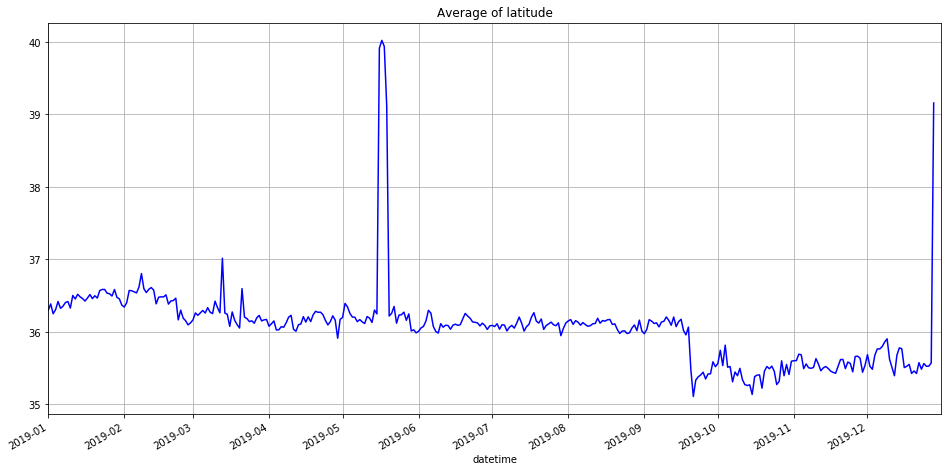

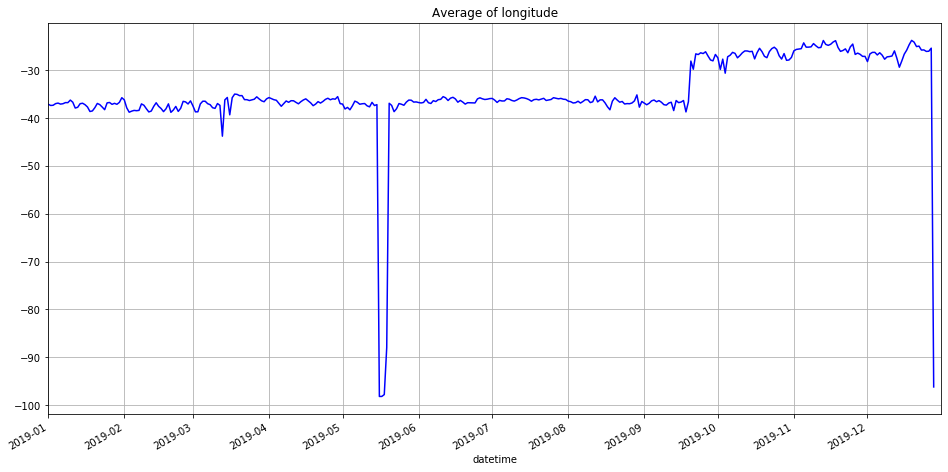

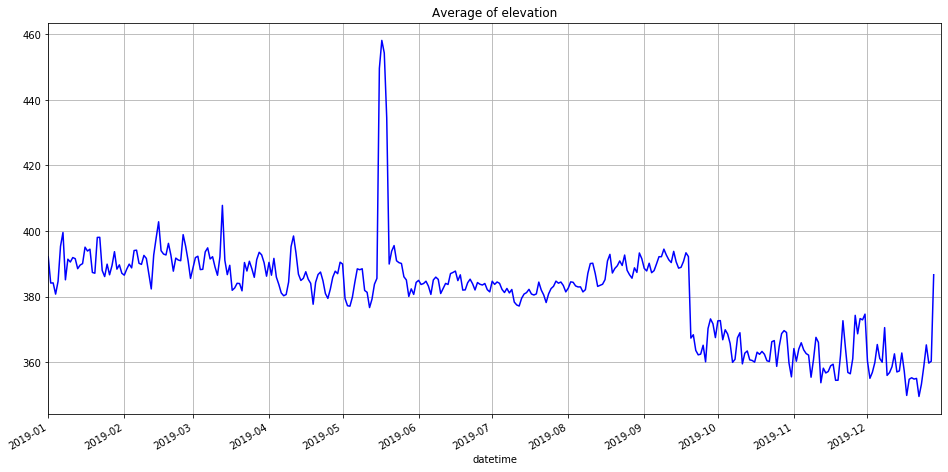

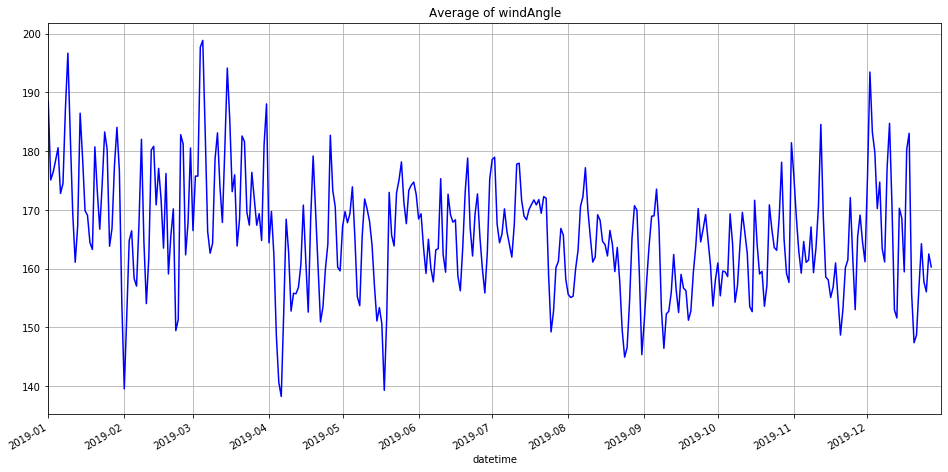

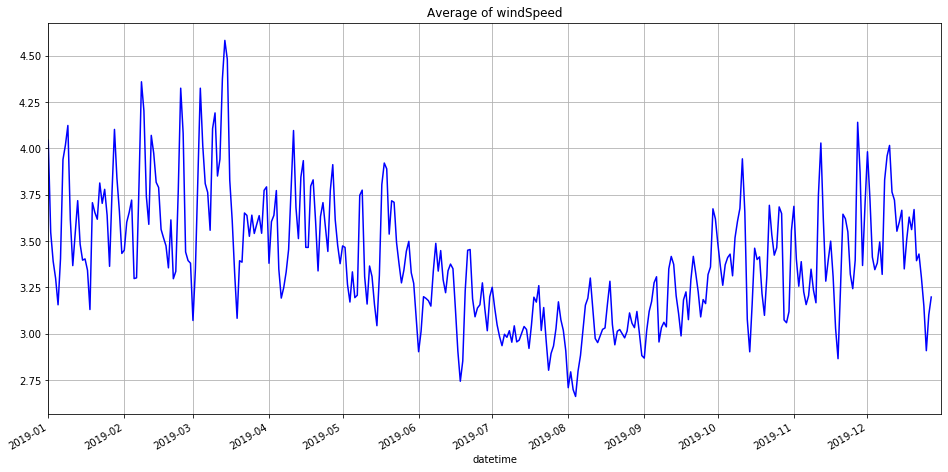

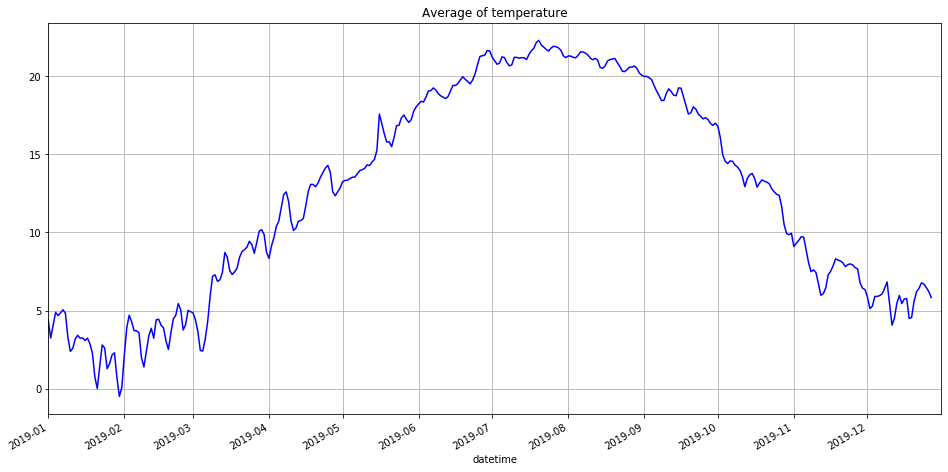

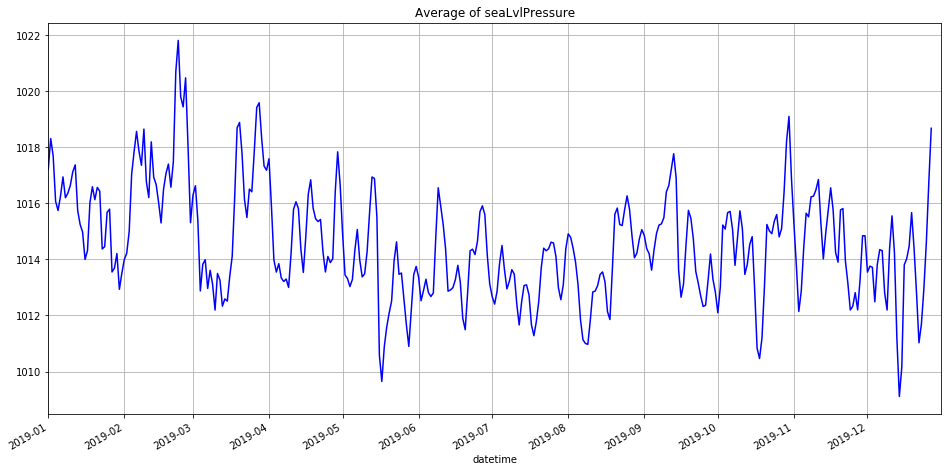

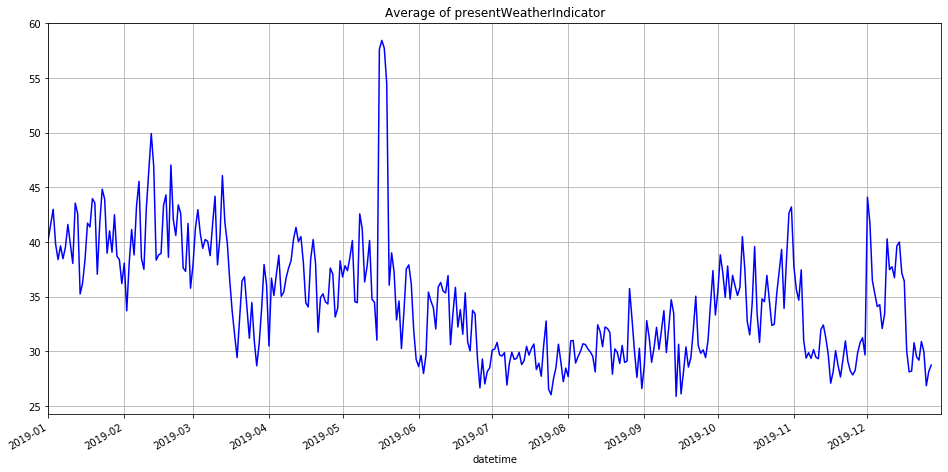

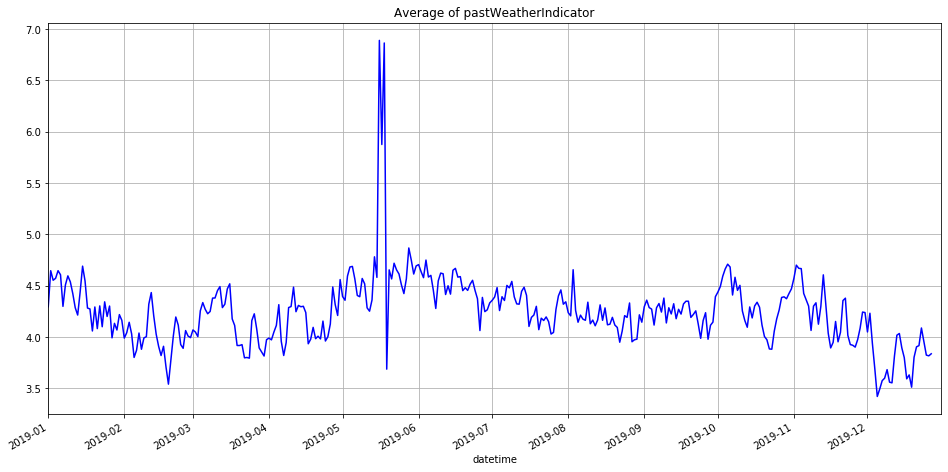

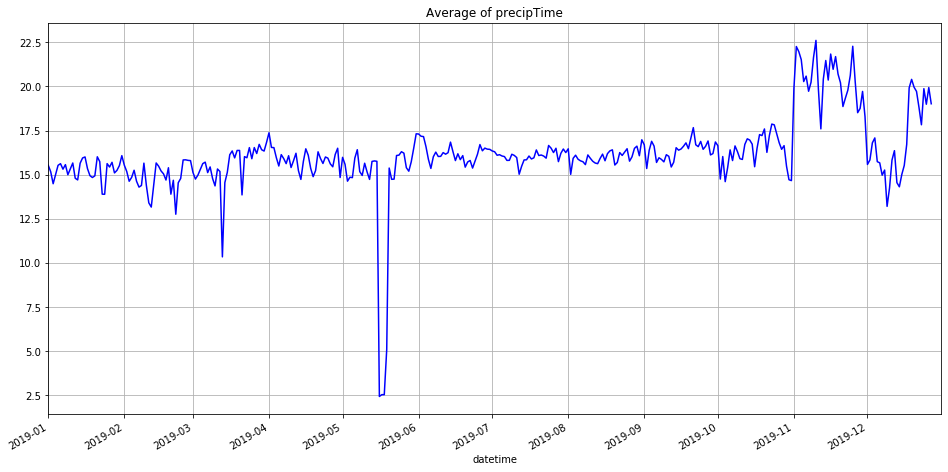

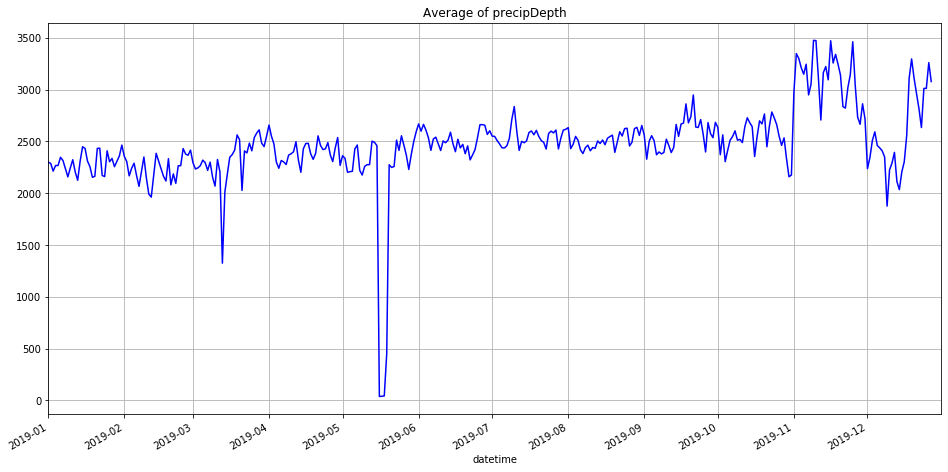

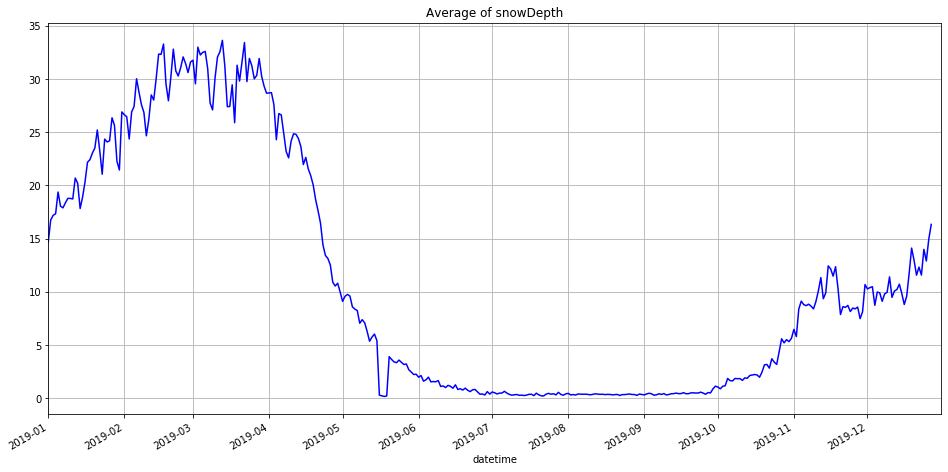

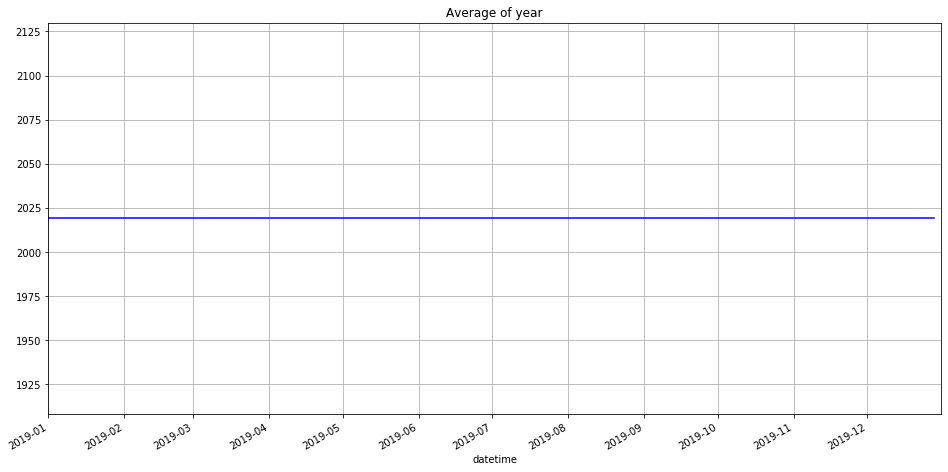

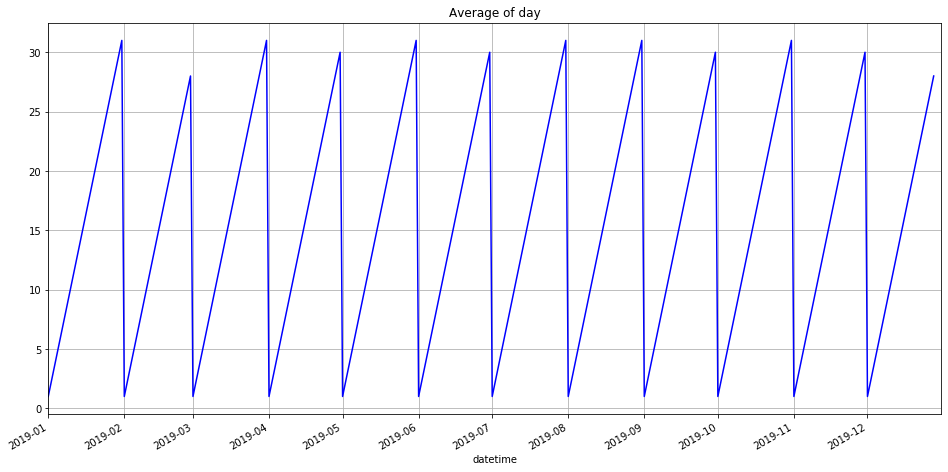

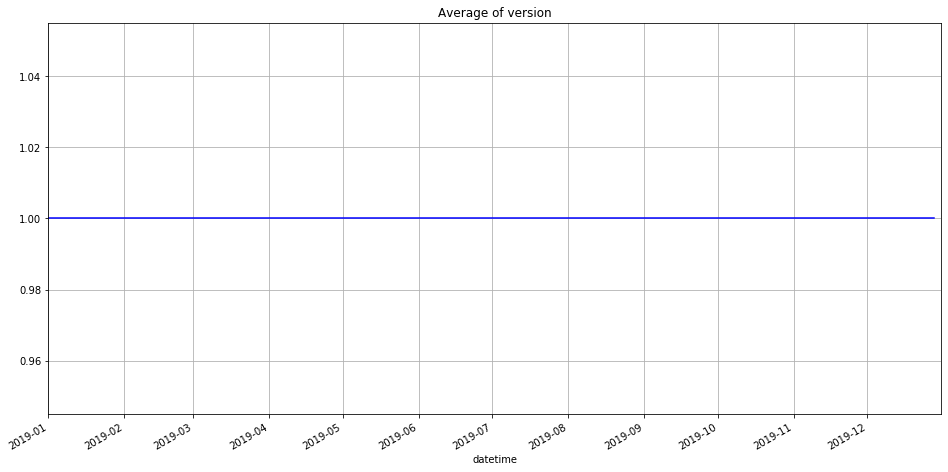

In [27]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2019, 1, 1), datetime(2019, 12, 31)])
    plt.grid()

In [28]:
c.close()

## Scale with Dask and Azure ML

Scale up to using the full dataset.

In [44]:
exp_name   = 'dask'
mount      = False
data_path  = '/mnt/noaa'
dset_input = ds.as_named_input('data').as_mount(data_path) if mount else ds.as_named_input('data').as_download(data_path)

script_params = {
    '--datastore': ws.get_default_datastore(),
    #'--script'   : 'run.py' # run code in run.py on cluster and teardown (batch processing)
}

est = Estimator('setup', 
                compute_target          = ct, 
                entry_script            = 'start.py', 
                environment_definition  = env, 
                script_params           = script_params,
                inputs                  = [dset_input],
                node_count              = 20,
                distributed_training    = MpiConfiguration()
               )

#run = next(ws.experiments[exp_name].get_runs()) # use this to get existing run (if kernel restarted, etc)
run = Experiment(ws, exp_name).submit(est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask,dask_1577737110_cebcadf6,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [45]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Wait for cluster to setup

Wait for the cluster to spin up, the run to start, and the `start.py` script to complete. At this point, information needed for connecting the cluster will be logged back to the run.

The below cell waits for that information to be logged to the run, sets up port forwarding for the Dask dashboard, and prints the url. Make sure to check out the dashboard as you run through the rest of the notebook.

In [47]:
# port to forward the dask dashboard to on the compute instance
# we do not use 8787 because it is already in use 
dashboard_port = 7070

print("waiting for scheduler node's ip")
while run.get_status() != 'Canceled' and 'scheduler' not in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

if run.get_status() == 'Canceled':
    print('Run was canceled')
else:
    print(f'Setting up port forwarding...')
    os.system(f'killall socat') # kill all socat processes - cleans up previous port forward setups 
    os.system(f'setsid socat tcp-listen:{dashboard_port},reuseaddr,fork tcp:{run.get_metrics()["dashboard"]} &')
    print(f'Cluster is ready to use.')

waiting for scheduler node's ip
Setting up port forwarding...
Cluster is ready to use.


### Connect to cluster

In [48]:
c = Client(f'tcp://{run.get_metrics()["scheduler"]}')
c.restart()

print(f'\n\n{c}')

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')



<Client: 'tcp://10.1.0.7:8786' processes=20 threads=160, memory=1.18 TB>


### Take all the data

In [49]:
files = dask.delayed(glob.glob)(f'{data_path}/year=*/month=*/*.parquet', recursive=True).compute()
files

['/mnt/noaa/year=2012/month=2/part-00011-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-64.c000.snappy.parquet',
 '/mnt/noaa/year=2012/month=5/part-00003-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-56.c000.snappy.parquet',
 '/mnt/noaa/year=2012/month=3/part-00001-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-54.c000.snappy.parquet',
 '/mnt/noaa/year=2012/month=10/part-00002-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-55.c000.snappy.parquet',
 '/mnt/noaa/year=2012/month=8/part-00007-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-60.c000.snappy.parquet',
 '/mnt/noaa/year=2012/month=12/part-00000-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-53.c000.snappy.parquet',
 '/mnt/noaa/year=2012/month=4/part-00005-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-58.c000.snappy.parquet',
 '/mnt/noaa/year=2012/month=1/part-00004-tid-7816671341480880202-0b49e80b-f206-4731-ab5a-61d53f99b595-57.c000

In [50]:
df = dd.from_delayed([dask.delayed(pd.read_parquet)(file) for file in files])
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,999999,03761,2012-02-01 00:00:00,39.859,-75.786,122.0,NaN,0.9,10.7,NaN,...,NaN,1.0,0.0,NaN,AVONDALE 2 N,US,999999-03761,2012,1,1.0
1,999999,03761,2012-02-01 00:05:00,39.859,-75.786,122.0,NaN,NaN,10.6,NaN,...,NaN,NaN,NaN,NaN,AVONDALE 2 N,US,999999-03761,2012,1,1.0
2,999999,03761,2012-02-01 00:10:00,39.859,-75.786,122.0,NaN,NaN,10.5,NaN,...,NaN,NaN,NaN,NaN,AVONDALE 2 N,US,999999-03761,2012,1,1.0
3,999999,03761,2012-02-01 00:15:00,39.859,-75.786,122.0,NaN,NaN,10.7,NaN,...,NaN,NaN,NaN,NaN,AVONDALE 2 N,US,999999-03761,2012,1,1.0
4,999999,03761,2012-02-01 00:20:00,39.859,-75.786,122.0,NaN,NaN,10.4,NaN,...,NaN,NaN,NaN,NaN,AVONDALE 2 N,US,999999-03761,2012,1,1.0


In [51]:
%time len(df)

CPU times: user 357 ms, sys: 45.7 ms, total: 402 ms
Wall time: 15.9 s


1395199999

In [52]:
%time df.describe().compute()

CPU times: user 6.46 s, sys: 394 ms, total: 6.86 s
Wall time: 2min 6s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.395200e+09,1.395200e+09,1.395200e+09,1.120397e+09,1.163526e+09,1.370008e+09,4.947240e+08,1.263201e+08,5.211754e+07,2.939545e+08,2.939545e+08,8.033333e+06,1.395200e+09,1.395200e+09,1.395200e+09
mean,3.743651e+01,-3.908364e+01,3.966978e+02,1.651781e+02,3.437612e+00,1.201580e+01,1.014648e+03,2.958524e+01,4.271468e+00,9.364511e+00,1.063696e+03,1.822055e+01,2.013761e+03,1.570308e+01,1.000000e+00
std,2.160154e+01,7.861962e+01,6.093392e+02,1.145221e+02,2.864323e+00,1.247473e+01,9.361065e+00,2.924391e+01,2.998584e+00,2.020093e+01,3.068290e+03,3.392483e+01,3.405101e+00,8.807051e+00,0.000000e+00
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,1.000000e+00,1.000000e+00
25%,3.405000e+01,-9.120000e+01,5.000000e+01,8.000000e+01,2.000000e+00,8.500000e+00,1.011700e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,8.000000e+00,1.000000e+00
50%,4.170600e+01,-5.057800e+01,2.090000e+02,1.900000e+02,3.600000e+00,1.610000e+01,1.017200e+03,4.900000e+01,6.000000e+00,3.000000e+00,0.000000e+00,1.500000e+01,2.016000e+03,1.600000e+01,1.000000e+00
75%,4.922000e+01,2.136700e+01,5.490000e+02,2.800000e+02,5.700000e+00,2.780000e+01,1.026000e+03,7.100000e+01,8.000000e+00,2.400000e+01,9.999000e+03,6.300000e+01,2.019000e+03,2.400000e+01,1.000000e+00
max,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.170000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.019000e+03,3.100000e+01,1.000000e+00


In [53]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 883 ms, sys: 104 ms, total: 988 ms
Wall time: 55.1 s
Dataframe is: 676.33GB


In [54]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean().compute()
means.head()

CPU times: user 2.61 s, sys: 643 ms, total: 3.25 s
Wall time: 4min 33s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2012-02-01,37.993272,-43.911948,448.228103,148.051930,3.456837,3.206922,1022.245928,31.371514,3.814271,5.409986,60.844379,30.812612,2012.0,1.0,1.0
2012-02-02,37.943888,-43.932926,450.886731,141.005051,3.219448,2.594951,1022.969061,33.393656,4.290726,5.514189,66.921622,30.898734,2012.0,2.0,1.0
2012-02-03,38.037231,-43.686844,459.549659,140.560733,3.434667,1.797780,1024.491884,31.580096,4.165509,5.396607,67.697823,30.740271,2012.0,3.0,1.0
2012-02-04,38.011718,-44.217380,454.513103,150.690401,3.563831,1.608438,1024.488932,30.887596,4.190449,5.175736,62.086209,30.680501,2012.0,4.0,1.0
2012-02-05,37.923877,-43.929567,452.743784,168.622456,3.409140,1.575598,1023.340668,28.387723,4.166780,5.429984,64.479056,27.676593,2012.0,5.0,1.0


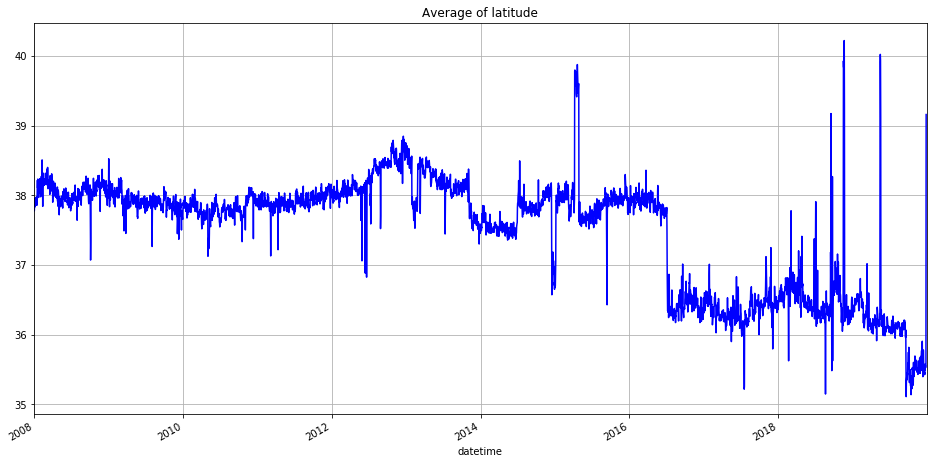

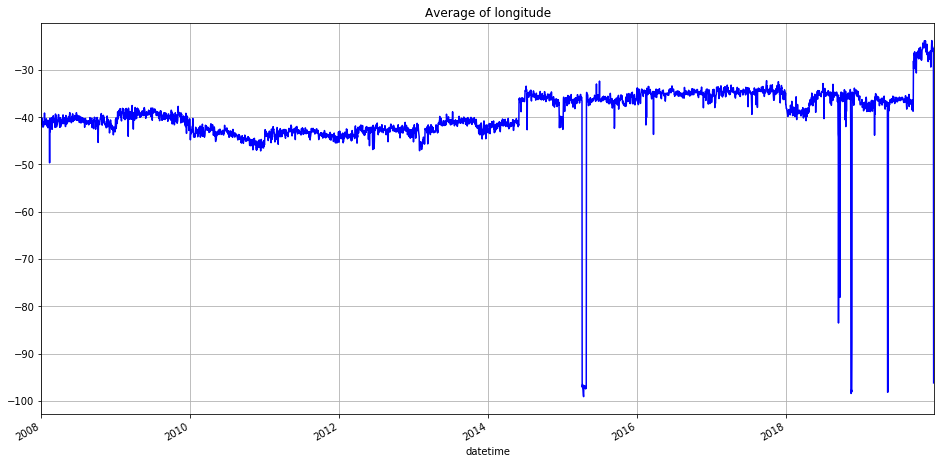

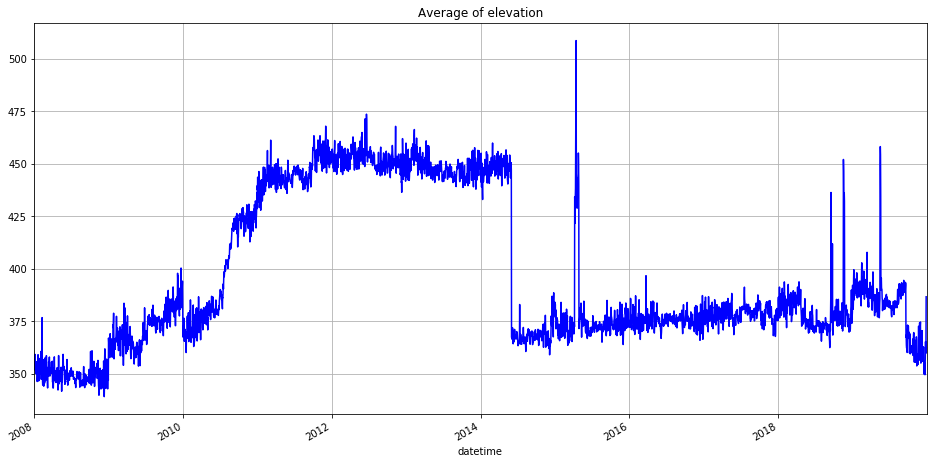

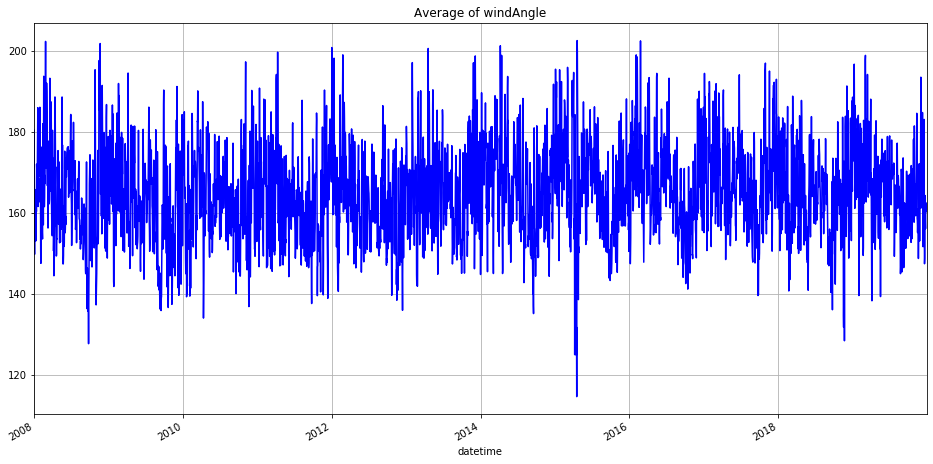

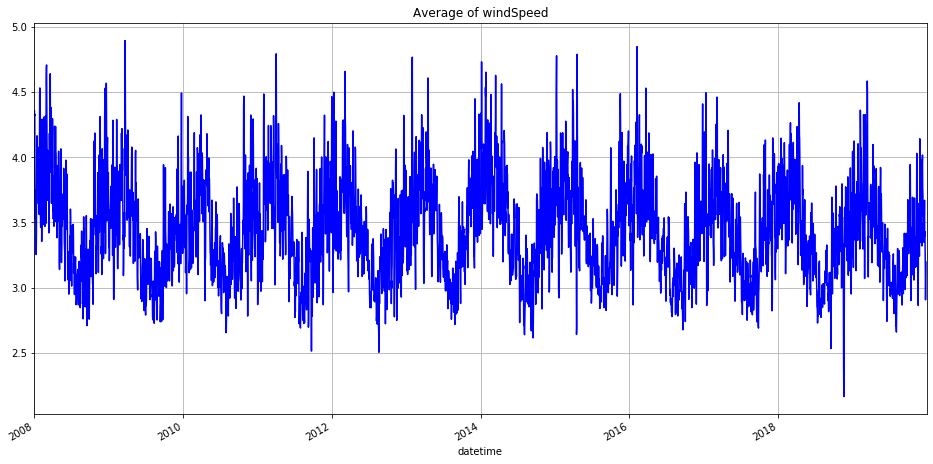

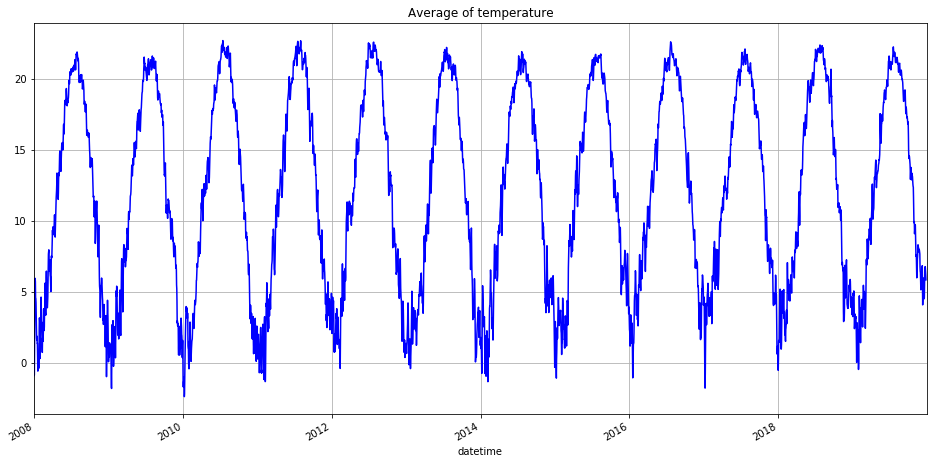

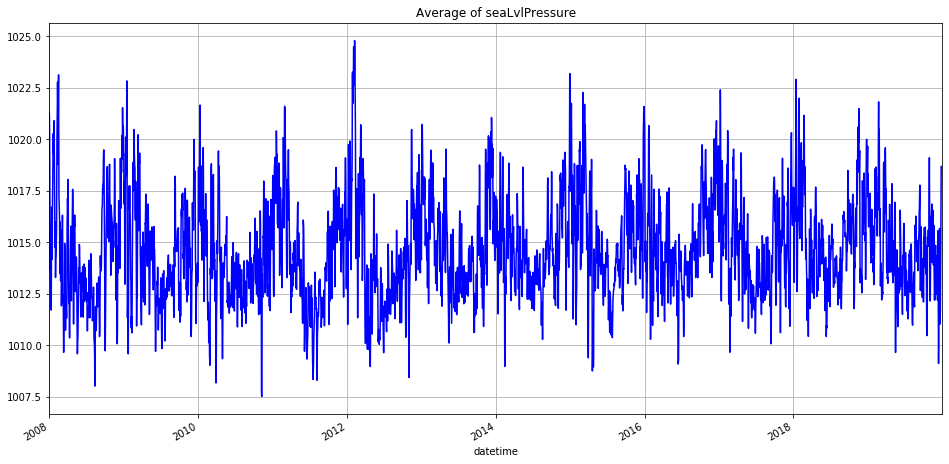

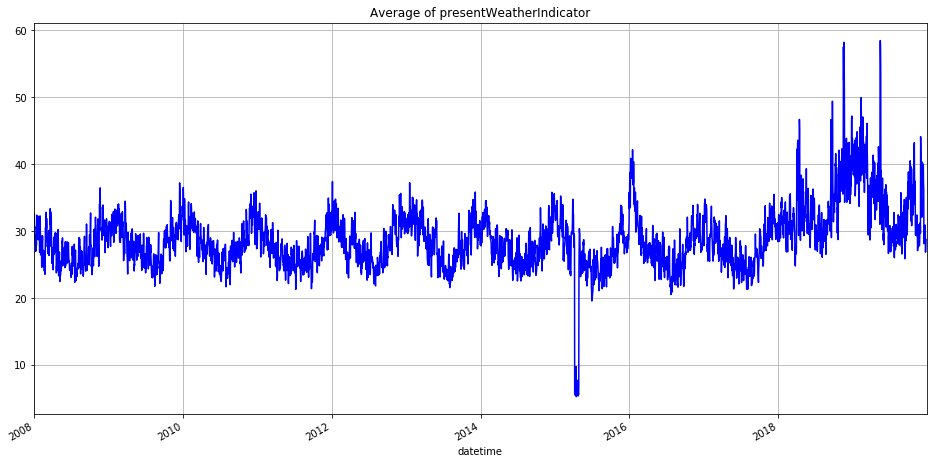

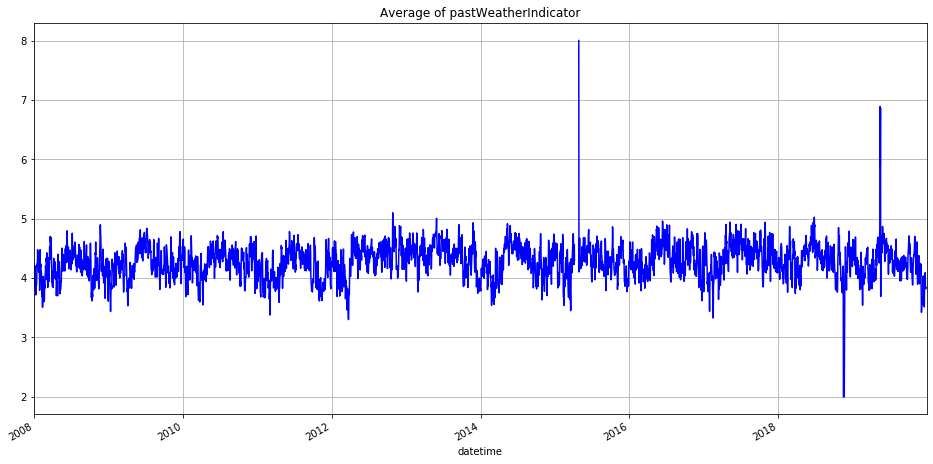

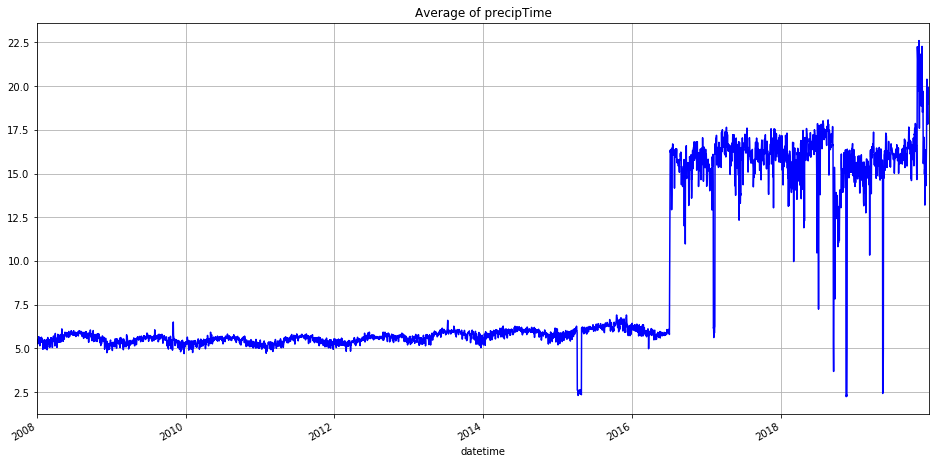

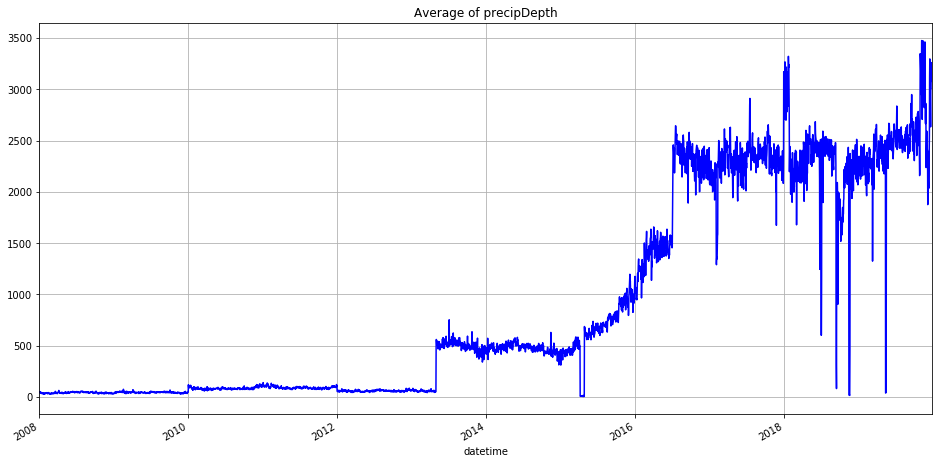

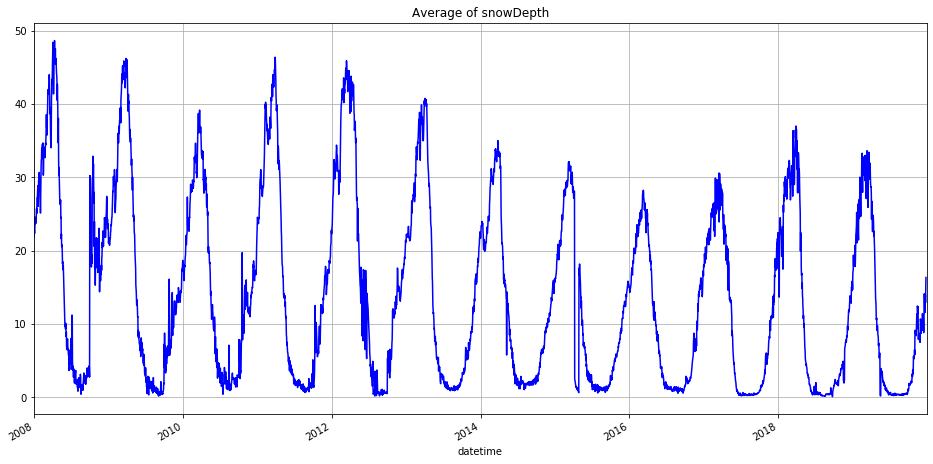

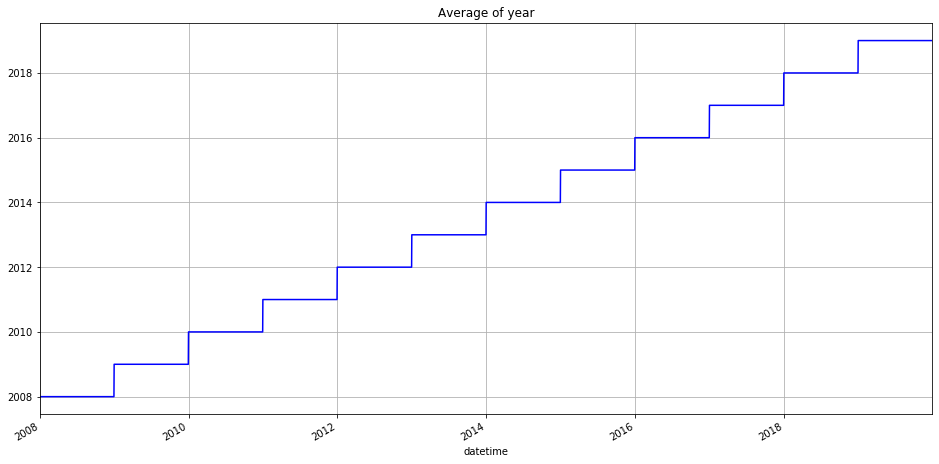

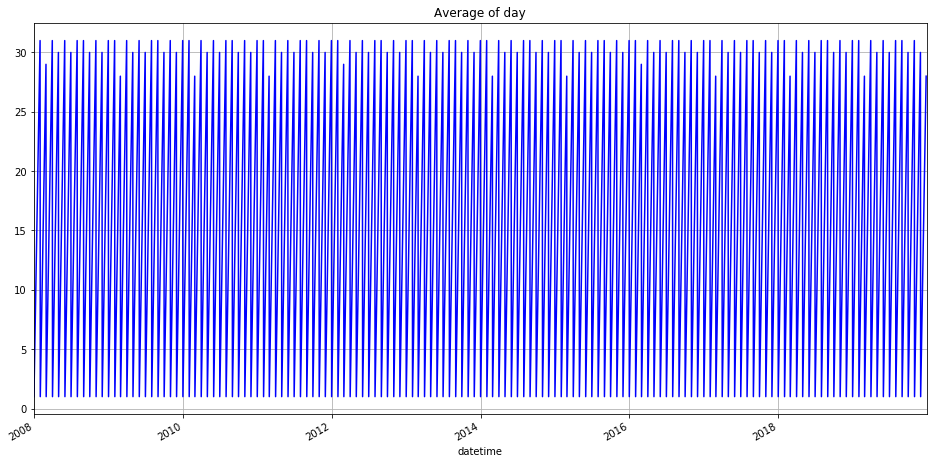

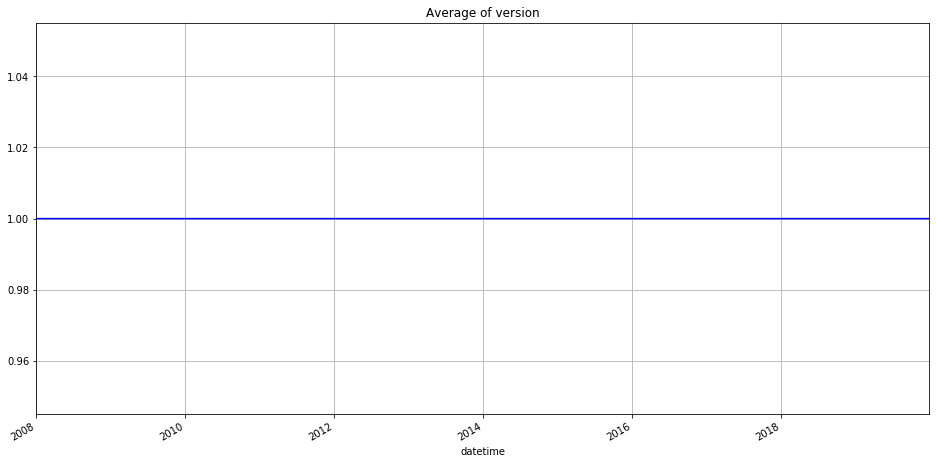

In [55]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime(2019, 12, 31)])
    plt.grid()

In [57]:
#df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False).persist()

## Prepare data

In [58]:
## insert any Pandas-like Dask data prep code 

## Write data

In [59]:
%time dask.delayed(df.to_parquet)(f'/{run.get_metrics()["datastore"]}/dask/output/noaa').compute()

CPU times: user 2.02 s, sys: 474 ms, total: 2.5 s
Wall time: 4min 56s


In [60]:
df

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,cloudCoverage,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
npartitions=144,,,,,,,,,,,,,,,,,,,,,,
,object,object,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,object,object,object,int32,int32,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Create dataset

In [61]:
from azureml.core import Dataset

dset = Dataset.File.from_files((ws.get_default_datastore(), '/dask/output/noaa/**/*.parquet'))

In [62]:
dset = dset.register(ws, 'weather-files-dask')
dset

{
  "source": [
    "('workspaceblobstore', 'dask/output/noaa/**/*.parquet')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "id": "4cc5fa86-6bc4-47a1-a85e-813ac214fc08",
    "name": "weather-files-dask",
    "version": 1,
    "workspace": "Workspace.create(name='bigdata', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')"
  }
}

## End the run

Cluster will return to 0 nodes

In [63]:
run.cancel()